# SIM-SOENS
This is a walkthrough of basic SIM-SOENs functionality, along with supporting input, readout, and analitic tools--all in a common syntax defined specifically for working with Simulated Superconducting Optoelectronic Networks (Sim-SOENs).

- Start with importing necesary libraries, modules, and Sim-SOEN-sepcific assets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from soen_sim import network
from soen_plotting import raster_plot
from super_net import SuperNet
from super_input import SuperInput
from super_library import NeuralZoo

from params import default_neuron_params

## Input
Before delving into neuron and network dynamics, let's first get familiar with input defitions.
- Significant felxibility is available for generating spiking input that is natively understood by Sim-SOENs.
- A few key parameters should be passed into the `Input` class.
- A number of hidden parameters may also be definted and are otherwise set to default values.
- The code below generates a single input channel of random spiking events for a duration of 100ns.

Generating random input...


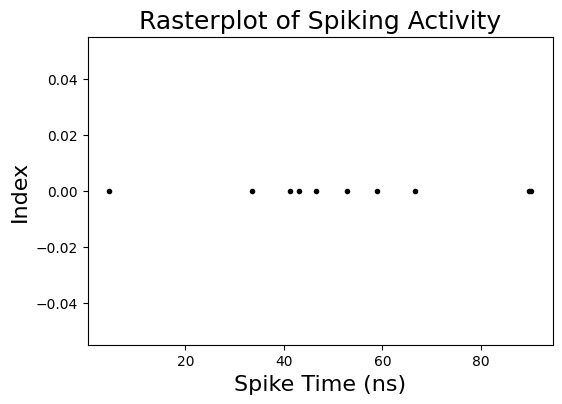

In [2]:
input_single = SuperInput(channels=1, type='random', total_spikes=10, duration=100)

raster_plot(input_single.spike_arrays,notebook=True)

Generating random input...


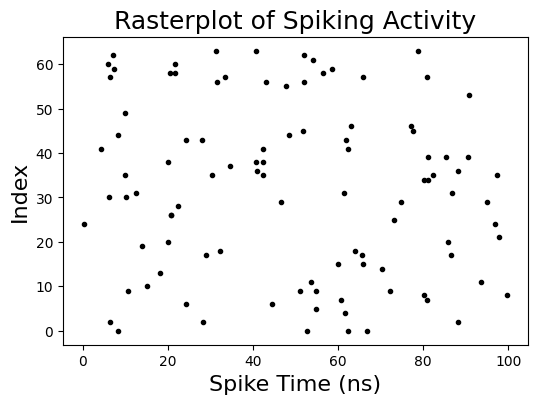

In [3]:
# More channels, more spikes
input_multi = SuperInput(channels=64, type='random', total_spikes=100, duration=100)
raster_plot(input_multi.spike_arrays,notebook=True)

### Spiking MNIST Dataset
The classic MNIST handwritten digit dataset can be generated by assigning each of the 28x28 pixels an input channel index, and generating Poisson spiking-even distributions with rates according to the pixel intensity at that pixel
- Note that the `slow_down` argument corresponds to the factor by which rates are slowed down (SOENs like data to have a frequency less that 1 spike per 35 ns)
- *Fix indexing and add all digits

Generating MNNIST dataset...
load
loaded
5


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


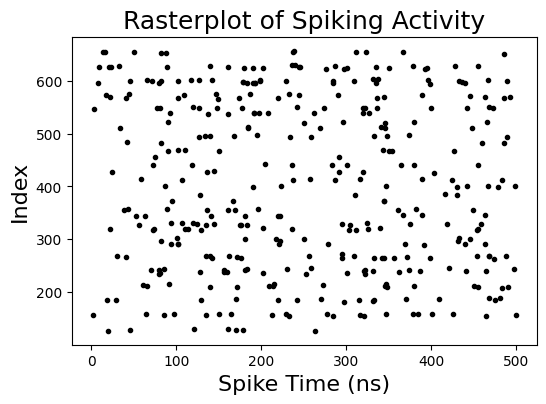

In [4]:
# *change to load previously generated patterns
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=10, duration=500)
raster_plot(input_MNIST.spike_arrays,notebook=True)

## The Neuron
SOEN neurons have special structure that corresponds to their physical design parameters.
- At least one SPD synaspse
- At least one SQUID-dendrite
- One SQUID soma
- One refractory SQUID-dendrite
- *A SQUID a superconducting quantum interference device, but computationally can be though of as a simple signal integrator with a leak

To call a simple single-synapse, single-dendrite neuron, use:

![ title](img/circuit_neuron.png)

### The Synapse
- A *single photon detector* responds to incoming light signals with a simple eponential rise and decay function
 - Photon trikes SPD
 - SPD enters resistive state
 - Provokes flux from SPD to Dendritic Receiver Loop according to 
$$\phi_r = \phi_{peak}(1-\frac{\tau_{rise}}{\tau_{fall}})\times   \left\{
\begin{array}{ll}
      [1-e^{-t/\tau_{rise}}] & 0 \leq t \leq t_0 \\
      [1-e^{-t_0/\tau_{rise}}]e^{-(t-t_0)/\tau_{fall}} &  t > t_0 \\
\end{array} 
\right.  $$ 
- $\phi_{peak} = 0.5$
- $t_0 \approx 200ps$
- $\tau_{rise}$ on order of ps
- $\tau_{fall}$ on order of ns

![ title](img/circuit_synapse.png)

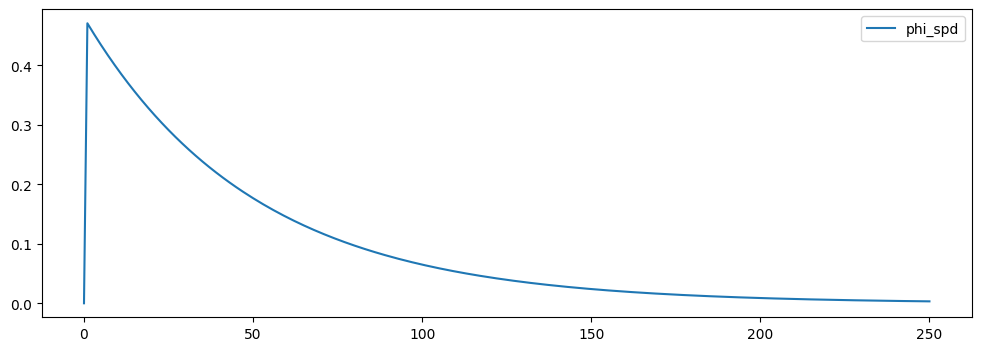

In [5]:
# define photon incidence on first (only synapse) at 5 ns and generate input
def_spikes = [[0],[.5]]
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=50)

# define a single neuron with default neuron parameters
sing = NeuralZoo(type='single',**default_neuron_params)
sing.synapse.add_input(input_.signals[0])

# create single-neuron netowork, add the neuron, and run
net = network(name = 'network_under_test',new_way=False)
net.add_neuron(sing.neuron)
net.run_sim(dt = .1, tf = 250)
net.get_recordings()

# pull SPD response from synapse through dendrite
spd = sing.dendrite.synaptic_inputs[1].phi_spd

# plot (skip 10 for dt of .1)
plt.figure(figsize=(12,4))
plt.plot(spd[::10], label='phi_spd')
plt.legend()

## The Dendrite
- The signal $s$ accumulated in the dendrite is defined by
$$\beta \frac{ds}{d\tau}=r(\phi,s;i_b)-\alpha s$$
- $\alpha$ and $\beta$ are physical constants that contribute signal decay over time
- $\phi$ is incoming flux (from SPD through dendritic receiving loop)
- $\tau$ the time constant of signal decay
- $i_b$ is the the bias current which will determine proximity to firing threshold
- $r(...)$  is a rate array function which has been numerically solved
  - The code backend pulls from saved solutions to rate arrays

![ title](img/rate_arrays.png)

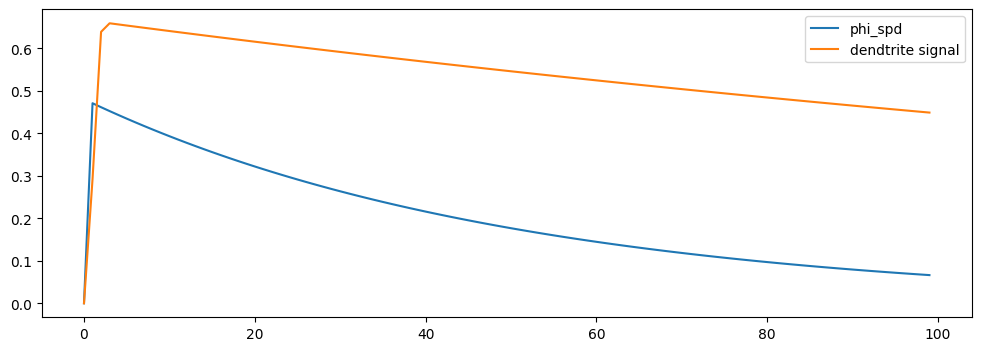

In [6]:
dend_s = sing.dendrite.s

plt.figure(figsize=(12,4))
plt.plot(spd[::10][:100], label='phi_spd')
plt.plot(dend_s[::10][:100], label='dendtrite signal')
plt.legend()


### Customizing parameters
- Default_neuron_parameters is simply a dictionary
- Any value for any key can of course be changed
- Print to see options
  - `_di` -> dendritic parameter
  - `_ni`  -> neuron (soma) parameters
  - `_ref` -> refractory parameters
  - `w_..` refers to connection strength between these elements (dn -> dendrite to neuron) 

In [7]:
for k,v in default_neuron_params.items():
    print(k," = ", v)

beta_di  =  628.3185307179587
tau_di  =  500
ib  =  1.802395858835221
ib_n  =  1.802395858835221
s_th  =  0.2
beta_ni  =  628.3185307179587
tau_ni  =  50
w_sd  =  1
w_sid  =  1
w_dd  =  0.5
w_dn  =  0.5
ib_ref  =  1.7523958588352209
beta_ref  =  628.3185307179587
tau_ref  =  50
ib_list_ri  =  [1.3523958588352205, 1.4023958588352206, 1.4523958588352206, 1.5023958588352206, 1.5523958588352207, 1.6023958588352207, 1.6523958588352208, 1.7023958588352208, 1.7523958588352209, 1.802395858835221, 1.852395858835221, 1.902395858835221, 1.952395858835221, 2.002395858835221, 2.0523958588352214]
s_max_n  =  0.7553237900539593


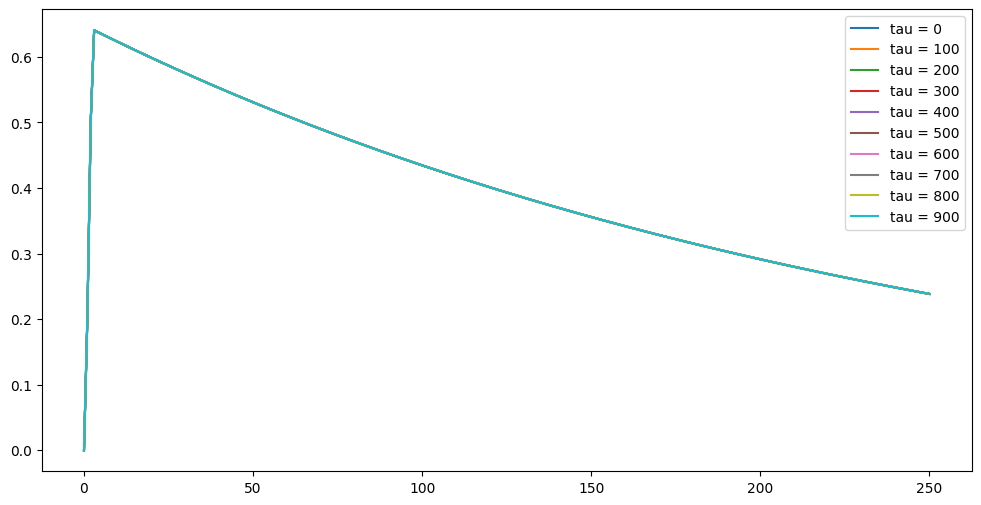

In [8]:
dendritic_signals = []
taus = np.arange(0,1000,100)
default_neuron_params['beta_di'] = np.pi*3*1e2
plt.figure(figsize=(12,6))
for tau in taus:

    # default parameters can always be adjusted before call
    default_neuron_params['tau_di'] = tau

    # this neuron now has a dendrite with a new time constant
    sing = NeuralZoo(type='single',**default_neuron_params)
    sing.synapse.add_input(input_.signals[0])

    net = network(name = 'network_under_test')
    net.add_neuron(sing.neuron)
    net.run_sim(dt = .1, tf = 250)
    net.get_recordings()
    dend_s = sing.dendrite.s
    dendritic_signals.append(dend_s)
    plt.plot(dend_s[::10], label=f'tau = {tau}')

# plt.plot(spd[::10], label='phi_spd')
plt.legend()
default_neuron_params['beta_di'] = np.pi*2*1e2

## The Soma
- Signal from any upstream dendrites is coupled to and interated by the soma
- When threshold is reached, soma: 
  - Depletes its stored signal
  - Invokes HTRON to activate silicon diode lightsource
  - Sends photons to all downstream neurons
  - Couple flux to refractory dendrite which recursively inhibits somatic signal
    - Refractory dendrite has its own adjustable dendritic parameters

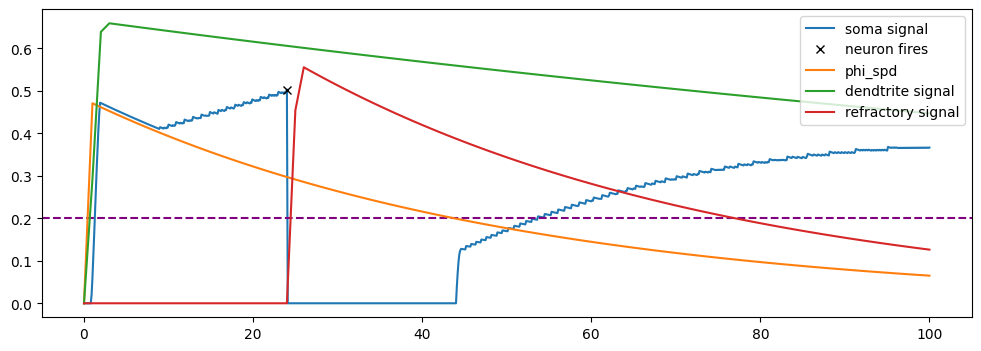

In [9]:
default_neuron_params["s_th_factor_n"] = 0.5
default_neuron_params['w_dn'] = 1
default_neuron_params['tau_di'] = 1000
default_neuron_params['tau_ref'] = 35
default_neuron_params['ib'] = 1.7
# default_neuron_params["beta_ni"] = 2*np.pi*1e3
def_spikes = [[0,0],[.5,10]]
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=100)

single = NeuralZoo(type='single',**default_neuron_params)
single.synapse.add_input(input_.signals[0])

net = network(name = 'network_under_test')
net.add_neuron(single.neuron)
net.run_sim(dt = .1, tf = 100)
net.get_recordings()

spd = single.dendrite.synaptic_inputs[1].phi_spd
dend_s = single.dendrite.s
signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s


plt.figure(figsize=(12,4))
plt.plot(net.t, net.signal[0], label='soma signal')
plt.plot(net.spikes[1],net.spike_signals[0],'xk', label='neuron fires')
plt.axhline(y = single.s_th, color = 'purple', linestyle = '--')
plt.plot(spd[::10], label='phi_spd')
plt.plot(dend_s[::10], label='dendtrite signal')
plt.plot(ref[::10], label='refractory signal')
plt.legend()

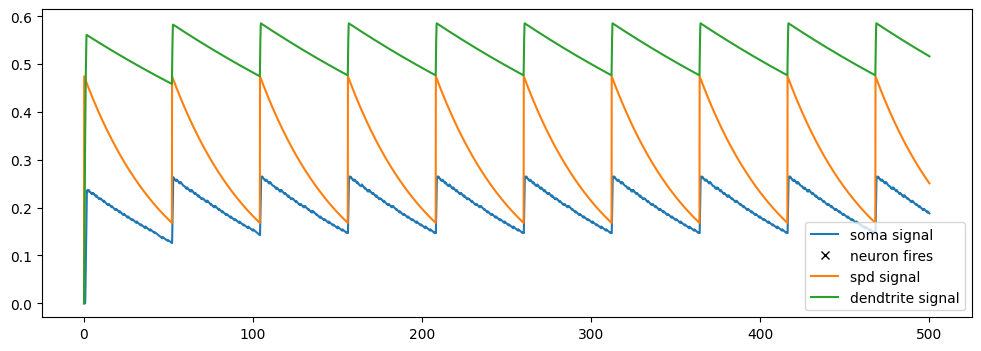

In [15]:
# define spike times
times = np.arange(0,500,52)
indices = np.zeros(len(times)).astype(int)
def_spikes = [indices,times]

# generate input
input = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=500)

weights = [[[0.5]]]

# no synapse on soma, synapse on first (only) dend
syn_struct = [[[[0]],[[1]]]] 

mono_dend = NeuralZoo(type="custom",weights=weights,synaptic_structure=syn_struct,
                      s_th=1, tau_di=250,tau_ref=50,ib_n=1.8,ib_di=1.7) 

mono_dend.synapses[0][1][0][0].add_input(input.signals[0])

net = network(sim=True,dt=.1,tf=500,nodes=[mono_dend])
title = "Monosynaptic Neuron with Intermediate Dendrite"

plt.figure(figsize=(12,4))
plt.plot(net.t,mono_dend.dendrites[0][0][0].s, label='soma signal')
plt.plot(net.spikes[1],net.spike_signals[0],'xk', label='neuron fires')
# plt.axhline(y = mono_dend.s_th, color = 'purple', linestyle = '--')
plt.plot(net.t,mono_dend.dendrites[1][0][0].phi_r, label='spd signal')
plt.plot(net.t,mono_dend.dendrites[1][0][0].s, label='dendtrite signal')

plt.legend()

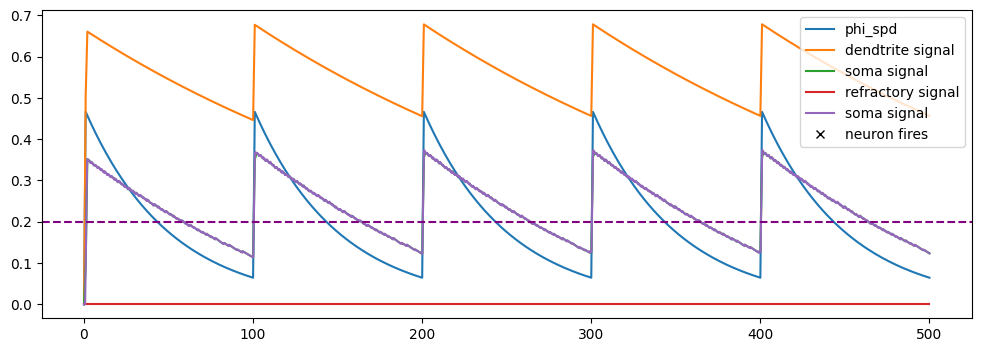

In [16]:
# define spike times
times = np.arange(0,500,50)
indices = np.zeros(len(times)).astype(int)
def_spikes = [indices,times]

# generate input
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=500)

# customize neuron parameters
default_neuron_params['w_dn'] = 0.5
default_neuron_params['tau_di'] = 10
default_neuron_params['tau_ref'] = 35
default_neuron_params["s_th_factor_n"] = 0.1
default_neuron_params['ib'] = 2


neo = NeuralZoo(type='single',**default_neuron_params)
neo.synapse.add_input(input_.signals[0])


net = network(name = 'network_under_test')
net.add_neuron(neo.neuron)
net.run_sim(dt = .1, tf = 500)
net.get_recordings()

spd = neo.dendrite.synaptic_inputs[1].phi_spd
dend_s = neo.dendrite.s
signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s

plt.figure(figsize=(12,4))
plt.plot(spd[::10], label='phi_spd')
plt.plot(dend_s[::10], label='dendtrite signal')
plt.plot(signal[::10], label='soma signal')
plt.plot(ref[::10], label='refractory signal')
plt.plot(net.t,net.signal[0], label='soma signal')
plt.plot(net.spikes[1],net.spike_signals[0],'xk', label='neuron fires')
plt.axhline(y = single.s_th, color = 'purple', linestyle = '--')
plt.legend()

## Dendritic Arbor
- A single synapse (currently) can only take input from $\approx1-10$ upstream sources
  - Comes with higher synaptic requirements to induce somatic firing
- To accomodate more sizeable fan-in, dendritic arbors may be constructed
- Signal of one dendrite coupled as flux into subsequent dendrite as
$$\phi_j = \sum^n_{j=1}J_{ij}s_i$$

![ title](img/circuit_dendrite.png)

![ title](img/arbor.png)

WARNING    c:\Users\rmo2\Desktop\sim_soens\super_library.py:821: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([i+.5, i+1.5], [k-3,j+3], '-k', color=colors[j])
 [py.warnings]
WARNING    c:\Users\rmo2\Desktop\sim_soens\super_library.py:823: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([len(layers)-.5, len(layers)+.5], [i+len(Ns),len(Ns)+1],
 [py.warnings]


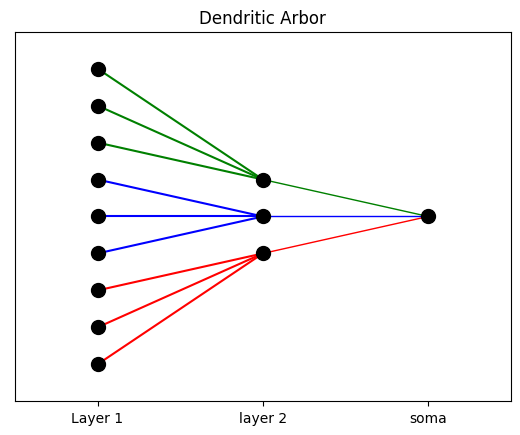

In [17]:
# custom parameters
default_neuron_params['w_dn'] = 0.9
default_neuron_params['w_dd'] = 0.9
default_neuron_params['tau_di'] = 10
default_neuron_params['tau_ref'] = 35
default_neuron_params["s_th"] = 0.2

# single 3-fractal neurons (9 synapses feed into 9 dendrites, feed into 3 dendrites, feed into 1 soma)
neo = NeuralZoo(type='3fractal',**default_neuron_params)
neo.plot_structure()

Generating random input...


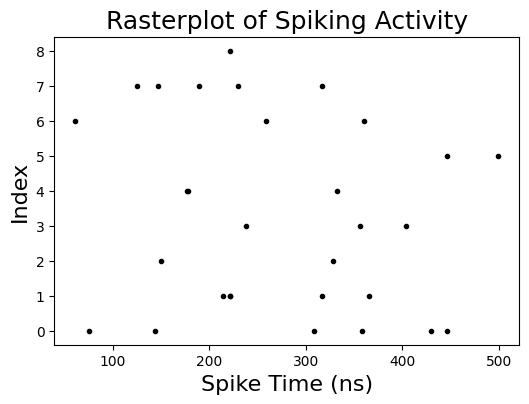

In [18]:
# generate and plot 8 dimensional random inpot
input = SuperInput(channels=9, type='random', total_spikes=30, duration=500)
raster_plot(input.spike_arrays,notebook=True)


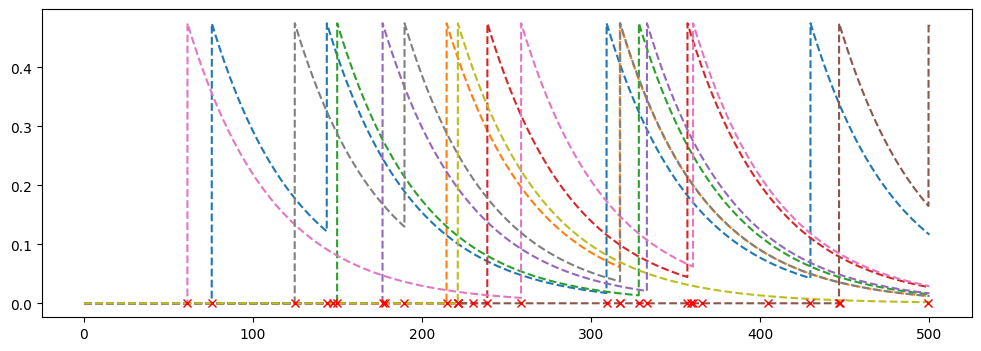

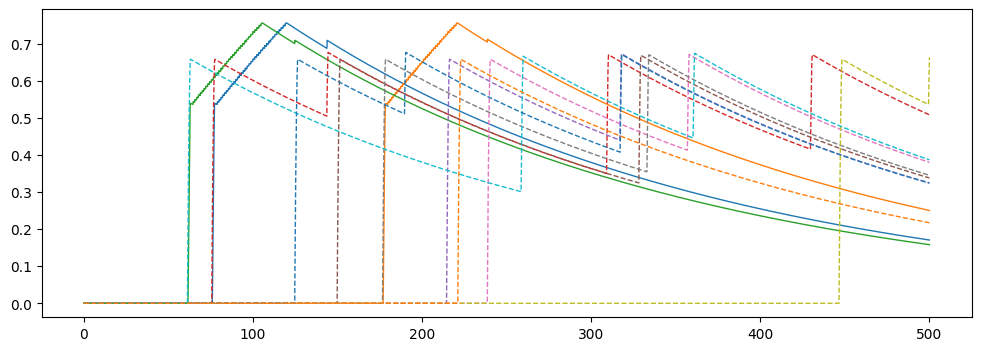

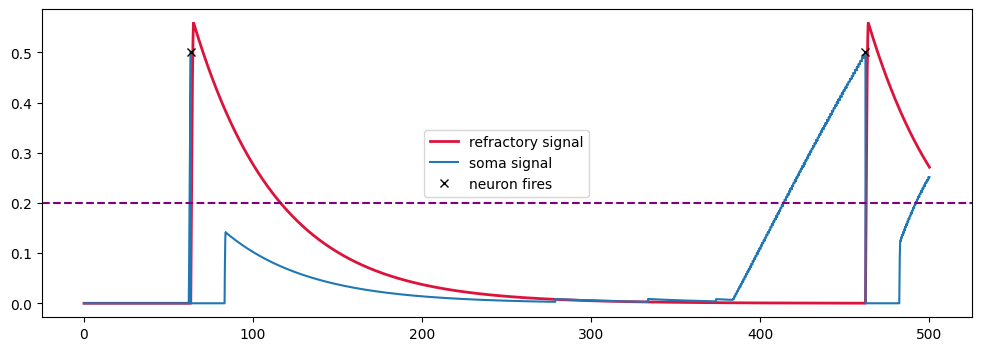

In [19]:
# Attach one input channel per synapse
for i in range(len(neo.synapses)):
    neo.synapses[i].add_input(input.signals[i])

# create and run network
net = network(name = 'network_under_test')
net.add_neuron(neo.fractal_neuron)
net.run_sim(dt = .01, tf = 500)
net.get_recordings()

signal = net.neurons[1].dend__nr_ni.s
ref = net.neurons[1].dend__ref.s
plt.figure(figsize=(12,4))

for i in range(len(neo.dendrites)):
    for j in range(len(neo.dendrites[i])):
        if i > 0:
            spd = neo.dendrites[i][j].synaptic_inputs[j].phi_spd
            plt.plot(net.t,spd,'--') #, label='phi_spd_'+str(i))
plt.plot(input.spike_arrays[1],np.zeros(len(input.spike_arrays[1])),'xr', label='input event')
plt.show()
plt.close()

plt.figure(figsize=(12,4))
for i in range(len(neo.dendrites)):
    for j in range(len(neo.dendrites[i])):
        dend_s = neo.dendrites[i][j].s
        if i == 0:
            plt.plot(net.t,dend_s,'-', linewidth=1, label='dend layer '+str(i))
        if i == 1:
            plt.plot(net.t,dend_s,'--', linewidth=1, label='dend layer '+str(i))

plt.show()
plt.close()
plt.figure(figsize=(12,4))
plt.plot(net.t,ref, linewidth=2, color='crimson', label='refractory signal')
plt.plot(net.t,net.signal[0], label='soma signal')
plt.plot(net.spikes[1],net.spike_signals[0],'xk', label='neuron fires')
plt.axhline(y = neo.s_th, color = 'purple', linestyle = '--')
plt.legend()
plt.show()
plt.close()

## Networking

In [14]:
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=100, duration=5000)

Generating MNNIST dataset...
load
loaded
5


In [15]:
# custom parameters
default_neuron_params['w_dn'] = 0.9
default_neuron_params['w_dd'] = 1
default_neuron_params['tau_di'] = .1
default_neuron_params['tau_ref'] = .1
default_neuron_params["s_th_factor_n"] = 0.1

from params import net_args
net_args['w_dn'] = [0.9]
net_args['w_dd'] = [1]
net_args['tau_di'] = [1,2] #.1
net_args['tau_ref'] = .1
net_args["s_th_factor_n"] = 0.1

# net_args['in_connect'] = 'ordered'
# net_args['connectivity'] = 0.42
neural_net = SuperNet(N=100,duration=5000,**net_args)

neural_net.connect_input(input_MNIST)
neural_net.run(dt=.1)
neural_net.record(['spikes'])

input neurons:  138
spikes


In [16]:
print(neural_net.net.neurons[1].tau_ref)
print(net_args['tau_ref'])

50
0.1


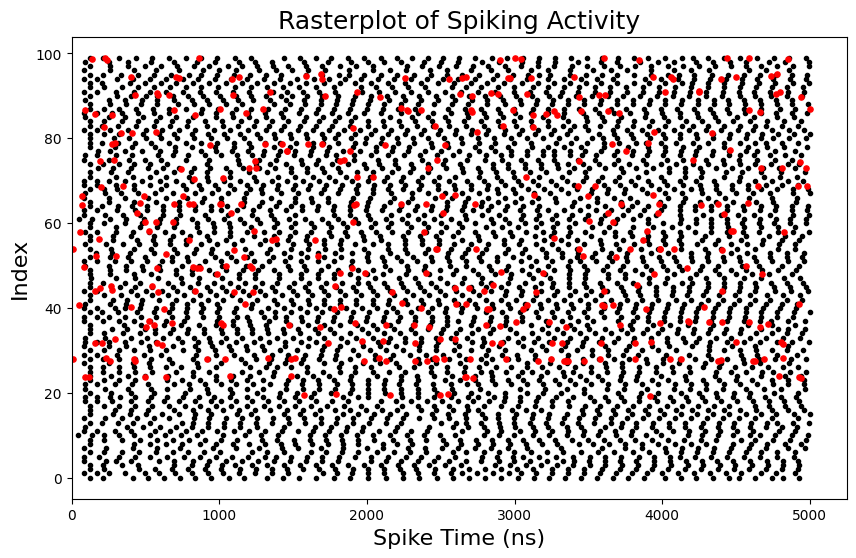

In [17]:
spikes = neural_net.spikes
spikes = [spikes[0],spikes[1]]
# raster_plot(input_MNIST.spike_arrays)
raster_plot(spikes,duration=5000,input=input_MNIST.spike_arrays)

100


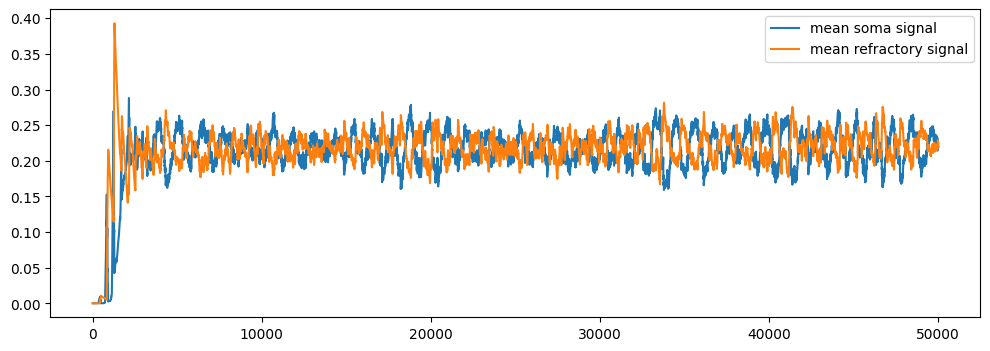

In [18]:
S = []
Phi_r = []
S_ref = []
DENDS = []
count = 0
for neuron_key in neural_net.net.neurons:

    phi_r = neural_net.neurons[neuron_key].dend__nr_ni.phi_r
    Phi_r.append(phi_r)

    # spd = neural_net.dendrites[neuron_key].dendrite.synaptic_inputs[1].phi_spd
    dend_s = neural_net.dendrites[neuron_key].s
    DENDS.append(dend_s)

    signal = neural_net.net.neurons[neuron_key].dend__nr_ni.s
    S.append(signal)
    ref = neural_net.net.neurons[neuron_key].dend__ref.s
    S_ref.append(ref)

print(len(S))
S_mean = np.mean(S, axis=0)
S_ref_mean = np.mean(S_ref, axis=0)
dend_mean = np.mean(DENDS, axis=0)

plt.figure(figsize=(12,4))
# # plt.plot(spd[::10], label='phi_spd')
# # plt.plot(dend_s[::10], label='dendtrite signal')
plt.plot(S_mean, label='mean soma signal')
plt.plot(S_ref_mean, label='mean refractory signal')
# plt.plot(dend_mean, label='mean dendritic signal')
# spike_height = [S_mean[int(net.spikes[1][x]*1000)] for x in range(len(net.spikes[1]))]
# plt.plot(spikes[1]*10, spike_height,'xk', label='neuron fires')
# plt.plot(spikes[1]*10, np.zeros(len(spikes[1])),'xk', label='neuron fires')
plt.legend()